In [1]:
from dgl import function as fn
from dgl.ops import edge_softmax
from dgl.base import DGLError
from dgl.utils import expand_as_pair
from dgl.nn.pytorch.utils import Identity

Using backend: pytorch


In [2]:
from dgllife.data import MoleculeCSVDataset
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer, mol_to_graph,PretrainAtomFeaturizer
from dgllife.model import GCNPredictor
from dgllife.model.gnn import GCN, GAT
from dgllife.model.readout import WeightedSumAndMax

In [3]:
import dgl
from torch.utils.data import DataLoader
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from argparse import Namespace
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from rdkit import Chem
from tqdm.notebook import tqdm


In [4]:
args = Namespace(
    raw_data_path = "../dataset/ci4000213_si_001.xlsx",
    train_sheet_name = "Train+Test",
    valid_sheet_name = "External validation",
    device = 'cuda' if th.cuda.is_available() else 'cpu',
    # -----------------------model hyperparameters------------------------
    model = 'GAT',
    train_batch_size = 64,
    valid_batch_size = 670,
    learning_rate = 0.005,
    in_feats =  74,
    nums_layer = 6,
    n_classes = 2,
    hidden_feats = [14] * 4, 
    activations  = [F.celu] * 4,
    residuals    = [True] * 4,
    batchnorms   = [True] * 4, 
    dropouts = [0.2] * 4,
    n_epoch = 100,
    # -------------------specail hyperparameters-------------------------
    num_heads = [4] * 4,
    feat_drops = [0.2] * 4,
    attn_drops = [0.2] * 4,
    agg_modes = ['flatten'] * 4,
    seed = 54321,
)
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if cuda:
        torch.cuda.manual_seed_all(seed)
set_seed_everywhere(args.seed, torch.cuda.is_available())

## 制作数据集

In [5]:
total_data = defaultdict(list)
total_raw_data = pd.read_excel(args.raw_data_path, sheet_name=args.train_sheet_name)
total_data['Status'] = total_raw_data['Status']
total_data['Smiles'] = total_raw_data['Smiles']
total_data['class']  = total_raw_data['Class'] 
total_data = pd.DataFrame(total_data)
total_data = shuffle(total_data, random_state=args.seed)
total_data['class'] = total_data['class'].apply(lambda x: int(0) if x == 'RB' else int(1))

total_data.head()

,Status,Smiles,class
387,Train,CNc1cccc(C)c1,1
271,Train,NCCCCCCN,0
815,Train,Nc1ccc2ccccc2c1[S](O)(=O)=O,1
205,Train,CC(=O)CC(=O)Nc1ccc(C)cc1,0
840,Test,CCCCNCCCC,0


In [6]:
train_data = total_data[total_data['Status'] == "Train"]
train_data.drop("Status", axis = 1, inplace = True)
print(train_data.head())
train_data['class'].value_counts()

                                      Smiles  class
387                            CNc1cccc(C)c1      1
271                                 NCCCCCCN      0
815              Nc1ccc2ccccc2c1[S](O)(=O)=O      1
205                 CC(=O)CC(=O)Nc1ccc(C)cc1      0
619  BrCC(Br)CO[P](=O)(OCC(Br)CBr)OCC(Br)CBr      1


1    553
0    284
Name: class, dtype: int64

In [7]:
test_data = total_data[total_data['Status'] == "Test"]
test_data.drop("Status", axis = 1, inplace=True)
print(test_data.head())
test_data['class'].value_counts()

                                Smiles  class
840                          CCCCNCCCC      0
950                       C=CC1CCC=CC1      1
908  CCCCCCCCCCCC(=O)OCC(O)C1OCC(O)C1O      0
934                       ClCCc1ccccc1      1
872                   C/C=C/C=C/C(O)=O      0


1    146
0     72
Name: class, dtype: int64

In [8]:
valid_data = defaultdict(list)
valid_raw_data = pd.read_excel(args.raw_data_path, sheet_name=args.valid_sheet_name)
valid_data['Smiles'] = valid_raw_data['Smiles']
valid_data['class']  = valid_raw_data['Class'] 
valid_data = pd.DataFrame(valid_data)
valid_data['class'] = valid_data['class'].apply(lambda x: int(0) if x == 'RB' else int(1))
print(valid_data.head())
valid_data["class"].value_counts()

                                              Smiles  class
0  COc1cc(N=Nc2c(Cl)cc(cc2N(=O)=O)N(=O)=O)c(cc1N(...      1
1  COc1cc(/N=N/c2ccc(cc2[N+](=O)[O-])[N+](=O)[O-]...      1
2  N#CCCN(c1ccc(c(c1)C)/N=N/c1nc2c(s1)cc(cc2)[N+]...      1
3   N#CCCN(c1ccc(cc1)/N=N/c1nc2c(s1)c(Cl)cc(c2)Cl)CC      1
4   N#CCCN(c1ccc(cc1)/N=N/c1sc2c(n1)cc(c(c2)Cl)Cl)CC      1


1    479
0    191
Name: class, dtype: int64

In [9]:
def smile_to_graph(smile, node_featurizer, edge_featurizer):
    graph = smiles_to_bigraph(smile,
                             node_featurizer = CanonicalAtomFeaturizer(atom_data_field='h'),
                             edge_featurizer = CanonicalBondFeaturizer(bond_data_field='e')
    )
    graph = dgl.remove_self_loop(graph)
    graph = dgl.add_self_loop(graph)
    return graph

In [10]:
def collate_molgraphs(data):
    """Batching a list of datapoints for dataloader.

    Parameters
    ----------
    data : list of 3-tuples or 4-tuples.
        Each tuple is for a single datapoint, consisting of
        a SMILES, a DGLGraph, all-task labels and optionally a binary
        mask indicating the existence of labels.

    Returns
    -------
    smiles : list
        List of smiles
    bg : DGLGraph
        The batched DGLGraph.
    labels : Tensor of dtype float32 and shape (B, T)
        Batched datapoint labels. B is len(data) and
        T is the number of total tasks.
    masks : Tensor of dtype float32 and shape (B, T)
        Batched datapoint binary mask, indicating the
        existence of labels.
    """
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)

    if len(data[0]) == 3:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)

    return smiles, bg, labels, masks

In [11]:
def get_dataloader(df, batch_size, shuffle, collate_fn, get_dataset = False):
    dataset = MoleculeCSVDataset(df = df, 
                                 smiles_to_graph=smile_to_graph,
                                 node_featurizer = None,
                                 edge_featurizer = None,
                                 smiles_column='Smiles', 
                                 cache_file_path="./degradation_valid.bin")
    if not get_dataset:
        return DataLoader(dataset = dataset, batch_size = batch_size, shuffle = shuffle, collate_fn = collate_fn)
    else:
        return dataset, DataLoader(dataset = dataset, batch_size = batch_size, shuffle = shuffle, collate_fn = collate_fn)


In [12]:
class GATConv(nn.Module):
    r"""

    Description
    -----------
    Apply `Graph Attention Network <https://arxiv.org/pdf/1710.10903.pdf>`__
    over an input signal.

    .. math::
        h_i^{(l+1)} = \sum_{j\in \mathcal{N}(i)} \alpha_{i,j} W^{(l)} h_j^{(l)}

    where :math:`\alpha_{ij}` is the attention score bewteen node :math:`i` and
    node :math:`j`:

    .. math::
        \alpha_{ij}^{l} &= \mathrm{softmax_i} (e_{ij}^{l})

        e_{ij}^{l} &= \mathrm{LeakyReLU}\left(\vec{a}^T [W h_{i} \| W h_{j}]\right)

    Parameters
    ----------
    in_feats : int, or pair of ints
        Input feature size; i.e, the number of dimensions of :math:`h_i^{(l)}`.
        ATConv can be applied on homogeneous graph and unidirectional
        `bipartite graph <https://docs.dgl.ai/generated/dgl.bipartite.html?highlight=bipartite>`__.
        If the layer is to be applied to a unidirectional bipartite graph, ``in_feats``
        specifies the input feature size on both the source and destination nodes.  If
        a scalar is given, the source and destination node feature size would take the
        same value.
    out_feats : int
        Output feature size; i.e, the number of dimensions of :math:`h_i^{(l+1)}`.
    num_heads : int
        Number of heads in Multi-Head Attention.
    feat_drop : float, optional
        Dropout rate on feature. Defaults: ``0``.
    attn_drop : float, optional
        Dropout rate on attention weight. Defaults: ``0``.
    negative_slope : float, optional
        LeakyReLU angle of negative slope. Defaults: ``0.2``.
    residual : bool, optional
        If True, use residual connection. Defaults: ``False``.
    activation : callable activation function/layer or None, optional.
        If not None, applies an activation function to the updated node features.
        Default: ``None``.
    allow_zero_in_degree : bool, optional
        If there are 0-in-degree nodes in the graph, output for those nodes will be invalid
        since no message will be passed to those nodes. This is harmful for some applications
        causing silent performance regression. This module will raise a DGLError if it detects
        0-in-degree nodes in input graph. By setting ``True``, it will suppress the check
        and let the users handle it by themselves. Defaults: ``False``.

    Note
    ----
    Zero in-degree nodes will lead to invalid output value. This is because no message
    will be passed to those nodes, the aggregation function will be appied on empty input.
    A common practice to avoid this is to add a self-loop for each node in the graph if
    it is homogeneous, which can be achieved by:

    >>> g = ... # a DGLGraph
    >>> g = dgl.add_self_loop(g)

    Calling ``add_self_loop`` will not work for some graphs, for example, heterogeneous graph
    since the edge type can not be decided for self_loop edges. Set ``allow_zero_in_degree``
    to ``True`` for those cases to unblock the code and handle zere-in-degree nodes manually.
    A common practise to handle this is to filter out the nodes with zere-in-degree when use
    after conv.

    Examples
    --------
    >>> import dgl
    >>> import numpy as np
    >>> import torch as th
    >>> from dgl.nn import GATConv

    >>> # Case 1: Homogeneous graph
    >>> g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))
    >>> g = dgl.add_self_loop(g)
    >>> feat = th.ones(6, 10)
    >>> gatconv = GATConv(10, 2, num_heads=3)
    >>> res = gatconv(g, feat)
    >>> res
    tensor([[[ 3.4570,  1.8634],
            [ 1.3805, -0.0762],
            [ 1.0390, -1.1479]],
            [[ 3.4570,  1.8634],
            [ 1.3805, -0.0762],
            [ 1.0390, -1.1479]],
            [[ 3.4570,  1.8634],
            [ 1.3805, -0.0762],
            [ 1.0390, -1.1479]],
            [[ 3.4570,  1.8634],
            [ 1.3805, -0.0762],
            [ 1.0390, -1.1479]],
            [[ 3.4570,  1.8634],
            [ 1.3805, -0.0762],
            [ 1.0390, -1.1479]],
            [[ 3.4570,  1.8634],
            [ 1.3805, -0.0762],
            [ 1.0390, -1.1479]]], grad_fn=<BinaryReduceBackward>)

    >>> # Case 2: Unidirectional bipartite graph
    >>> u = [0, 1, 0, 0, 1]
    >>> v = [0, 1, 2, 3, 2]
    >>> g = dgl.bipartite((u, v))
    >>> u_feat = th.tensor(np.random.rand(2, 5).astype(np.float32))
    >>> v_feat = th.tensor(np.random.rand(4, 10).astype(np.float32))
    >>> gatconv = GATConv((5,10), 2, 3)
    >>> res = gatconv(g, (u_feat, v_feat))
    >>> res
    tensor([[[-0.6066,  1.0268],
            [-0.5945, -0.4801],
            [ 0.1594,  0.3825]],
            [[ 0.0268,  1.0783],
            [ 0.5041, -1.3025],
            [ 0.6568,  0.7048]],
            [[-0.2688,  1.0543],
            [-0.0315, -0.9016],
            [ 0.3943,  0.5347]],
            [[-0.6066,  1.0268],
            [-0.5945, -0.4801],
            [ 0.1594,  0.3825]]], grad_fn=<BinaryReduceBackward>)
    """
    def __init__(self,
                 in_feats,
                 out_feats,
                 num_heads,
                 feat_drop=0.,
                 attn_drop=0.,
                 negative_slope=0.2,
                 residual=False,
                 activation=None,
                 allow_zero_in_degree=False):
        super(GATConv, self).__init__()
        self._num_heads = num_heads
        self._in_src_feats, self._in_dst_feats = expand_as_pair(in_feats)
        self._out_feats = out_feats
        self._allow_zero_in_degree = allow_zero_in_degree
        if isinstance(in_feats, tuple):
            self.fc_src = nn.Linear(
                self._in_src_feats, out_feats * num_heads, bias=False)
            self.fc_dst = nn.Linear(
                self._in_dst_feats, out_feats * num_heads, bias=False)
        else:
            self.fc = nn.Linear(
                self._in_src_feats, out_feats * num_heads, bias=False)
        self.attn_l = nn.Parameter(th.FloatTensor(size=(1, num_heads, out_feats)))
        self.attn_r = nn.Parameter(th.FloatTensor(size=(1, num_heads, out_feats)))
        self.feat_drop = nn.Dropout(feat_drop)
        self.attn_drop = nn.Dropout(attn_drop)
        self.leaky_relu = nn.LeakyReLU(negative_slope)
        if residual:
            if self._in_dst_feats != out_feats:
                self.res_fc = nn.Linear(
                    self._in_dst_feats, num_heads * out_feats, bias=False)
            else:
                self.res_fc = Identity()
        else:
            self.register_buffer('res_fc', None)
        self.reset_parameters()
        self.activation = activation

    def reset_parameters(self):
        """

        Description
        -----------
        Reinitialize learnable parameters.

        Note
        ----
        The fc weights :math:`W^{(l)}` are initialized using Glorot uniform initialization.
        The attention weights are using xavier initialization method.
        """
        gain = nn.init.calculate_gain('relu')
        if hasattr(self, 'fc'):
            nn.init.xavier_normal_(self.fc.weight, gain=gain)
        else:
            nn.init.xavier_normal_(self.fc_src.weight, gain=gain)
            nn.init.xavier_normal_(self.fc_dst.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_l, gain=gain)
        nn.init.xavier_normal_(self.attn_r, gain=gain)
        if isinstance(self.res_fc, nn.Linear):
            nn.init.xavier_normal_(self.res_fc.weight, gain=gain)

    def set_allow_zero_in_degree(self, set_value):
        r"""

        Description
        -----------
        Set allow_zero_in_degree flag.

        Parameters
        ----------
        set_value : bool
            The value to be set to the flag.
        """
        self._allow_zero_in_degree = set_value

    def forward(self, graph, feat):
        r"""

        Description
        -----------
        Compute graph attention network layer.

        Parameters
        ----------
        graph : DGLGraph
            The graph.
        feat : torch.Tensor or pair of torch.Tensor
            If a torch.Tensor is given, the input feature of shape :math:`(N, D_{in})` where
            :math:`D_{in}` is size of input feature, :math:`N` is the number of nodes.
            If a pair of torch.Tensor is given, the pair must contain two tensors of shape
            :math:`(N_{in}, D_{in_{src}})` and :math:`(N_{out}, D_{in_{dst}})`.

        Returns
        -------
        torch.Tensor
            The output feature of shape :math:`(N, H, D_{out})` where :math:`H`
            is the number of heads, and :math:`D_{out}` is size of output feature.

        Raises
        ------
        DGLError
            If there are 0-in-degree nodes in the input graph, it will raise DGLError
            since no message will be passed to those nodes. This will cause invalid output.
            The error can be ignored by setting ``allow_zero_in_degree`` parameter to ``True``.
        """
        with graph.local_scope():
            if not self._allow_zero_in_degree:
                if (graph.in_degrees() == 0).any():
                    raise DGLError('There are 0-in-degree nodes in the graph, '
                                   'output for those nodes will be invalid. '
                                   'This is harmful for some applications, '
                                   'causing silent performance regression. '
                                   'Adding self-loop on the input graph by '
                                   'calling `g = dgl.add_self_loop(g)` will resolve '
                                   'the issue. Setting ``allow_zero_in_degree`` '
                                   'to be `True` when constructing this module will '
                                   'suppress the check and let the code run.')

            if isinstance(feat, tuple):
                h_src = self.feat_drop(feat[0])
                h_dst = self.feat_drop(feat[1])
                if not hasattr(self, 'fc_src'):
                    self.fc_src, self.fc_dst = self.fc, self.fc
                feat_src = self.fc_src(h_src).view(-1, self._num_heads, self._out_feats)
                feat_dst = self.fc_dst(h_dst).view(-1, self._num_heads, self._out_feats)
            else:
                h_src = h_dst = self.feat_drop(feat)
                feat_src = feat_dst = self.fc(h_src).view(
                    -1, self._num_heads, self._out_feats)
                if graph.is_block:
                    feat_dst = feat_src[:graph.number_of_dst_nodes()]
            # NOTE: GAT paper uses "first concatenation then linear projection"
            # to compute attention scores, while ours is "first projection then
            # addition", the two approaches are mathematically equivalent:
            # We decompose the weight vector a mentioned in the paper into
            # [a_l || a_r], then
            # a^T [Wh_i || Wh_j] = a_l Wh_i + a_r Wh_j
            # Our implementation is much efficient because we do not need to
            # save [Wh_i || Wh_j] on edges, which is not memory-efficient. Plus,
            # addition could be optimized with DGL's built-in function u_add_v,
            # which further speeds up computation and saves memory footprint.
            el = (feat_src * self.attn_l).sum(dim=-1).unsqueeze(-1)
            er = (feat_dst * self.attn_r).sum(dim=-1).unsqueeze(-1)
            graph.srcdata.update({'ft': feat_src, 'el': el})
            graph.dstdata.update({'er': er})
            # compute edge attention, el and er are a_l Wh_i and a_r Wh_j respectively.
            graph.apply_edges(fn.u_add_v('el', 'er', 'e'))
            e = self.leaky_relu(graph.edata.pop('e'))
            # compute softmax
            att = edge_softmax(graph, e)
            graph.edata['a'] = self.attn_drop(edge_softmax(graph, e))
            # message passing
            graph.update_all(fn.u_mul_e('ft', 'a', 'm'),
                             fn.sum('m', 'ft'))
            rst = graph.dstdata['ft']
            # residual
            if self.res_fc is not None:
                resval = self.res_fc(h_dst).view(h_dst.shape[0], -1, self._out_feats)
                rst = rst + resval
            # activation
            if self.activation:
                rst = self.activation(rst)
            return rst, att


In [13]:
# -*- coding: utf-8 -*-
#
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Graph Attention Networks
#
# pylint: disable= no-member, arguments-differ, invalid-name

#import torch.nn as nn
#import torch.nn.functional as F

#from dgl.nn.pytorch import GATConv

class GATLayer(nn.Module):
    r"""Single GAT layer from `Graph Attention Networks <https://arxiv.org/abs/1710.10903>`__

    Parameters
    ----------
    in_feats : int
        Number of input node features
    out_feats : int
        Number of output node features
    num_heads : int
        Number of attention heads
    feat_drop : float
        Dropout applied to the input features
    attn_drop : float
        Dropout applied to attention values of edges
    alpha : float
        Hyperparameter in LeakyReLU, which is the slope for negative values.
        Default to 0.2.
    residual : bool
        Whether to perform skip connection, default to True.
    agg_mode : str
        The way to aggregate multi-head attention results, can be either
        'flatten' for concatenating all-head results or 'mean' for averaging
        all head results.
    activation : activation function or None
        Activation function applied to the aggregated multi-head results, default to None.
    """
    def __init__(self, in_feats, out_feats, num_heads, feat_drop, attn_drop,
                 alpha=0.2, residual=True, agg_mode='flatten', activation=None):
        super(GATLayer, self).__init__()

        self.gat_conv = GATConv(in_feats=in_feats, out_feats=out_feats, num_heads=num_heads,
                                feat_drop=feat_drop, attn_drop=attn_drop,
                                negative_slope=alpha, residual=residual)
        assert agg_mode in ['flatten', 'mean']
        self.agg_mode = agg_mode
        self.activation = activation

    def reset_parameters(self):
        """Reinitialize model parameters."""
        self.gat_conv.reset_parameters()

    def forward(self, bg, feats):
        """Update node representations

        Parameters
        ----------
        bg : DGLGraph
            DGLGraph for a batch of graphs.
        feats : FloatTensor of shape (N, M1)
            * N is the total number of nodes in the batch of graphs
            * M1 is the input node feature size, which equals in_feats in initialization

        Returns
        -------
        feats : FloatTensor of shape (N, M2)
            * N is the total number of nodes in the batch of graphs
            * M2 is the output node representation size, which equals
              out_feats in initialization if self.agg_mode == 'mean' and
              out_feats * num_heads in initialization otherwise.
        """
        feats, att = self.gat_conv(bg, feats)
        if self.agg_mode == 'flatten':
            feats = feats.flatten(1)
        else:
            feats = feats.mean(1)

        if self.activation is not None:
            feats = self.activation(feats)

        return feats, att

class GAT(nn.Module):
    r"""GAT from `Graph Attention Networks <https://arxiv.org/abs/1710.10903>`__

    Parameters
    ----------
    in_feats : int
        Number of input node features
    hidden_feats : list of int
        ``hidden_feats[i]`` gives the output size of an attention head in the i-th GAT layer.
        ``len(hidden_feats)`` equals the number of GAT layers. By default, we use ``[32, 32]``.
    num_heads : list of int
        ``num_heads[i]`` gives the number of attention heads in the i-th GAT layer.
        ``len(num_heads)`` equals the number of GAT layers. By default, we use 4 attention heads
        for each GAT layer.
    feat_drops : list of float
        ``feat_drops[i]`` gives the dropout applied to the input features in the i-th GAT layer.
        ``len(feat_drops)`` equals the number of GAT layers. By default, this will be zero for
        all GAT layers.
    attn_drops : list of float
        ``attn_drops[i]`` gives the dropout applied to attention values of edges in the i-th GAT
        layer. ``len(attn_drops)`` equals the number of GAT layers. By default, this will be zero
        for all GAT layers.
    alphas : list of float
        Hyperparameters in LeakyReLU, which are the slopes for negative values. ``alphas[i]``
        gives the slope for negative value in the i-th GAT layer. ``len(alphas)`` equals the
        number of GAT layers. By default, this will be 0.2 for all GAT layers.
    residuals : list of bool
        ``residual[i]`` decides if residual connection is to be used for the i-th GAT layer.
        ``len(residual)`` equals the number of GAT layers. By default, residual connection
        is performed for each GAT layer.
    agg_modes : list of str
        The way to aggregate multi-head attention results for each GAT layer, which can be either
        'flatten' for concatenating all-head results or 'mean' for averaging all-head results.
        ``agg_modes[i]`` gives the way to aggregate multi-head attention results for the i-th
        GAT layer. ``len(agg_modes)`` equals the number of GAT layers. By default, we flatten
        all-head results for each GAT layer.
    activations : list of activation function or None
        ``activations[i]`` gives the activation function applied to the aggregated multi-head
        results for the i-th GAT layer. ``len(activations)`` equals the number of GAT layers.
        By default, no activation is applied for each GAT layer.
    """
    def __init__(self, in_feats, hidden_feats=None, num_heads=None, feat_drops=None,
                 attn_drops=None, alphas=None, residuals=None, agg_modes=None, activations=None):
        super(GAT, self).__init__()

        if hidden_feats is None:
            hidden_feats = [32, 32]

        n_layers = len(hidden_feats)
        if num_heads is None:
            num_heads = [4 for _ in range(n_layers)]
        if feat_drops is None:
            feat_drops = [0. for _ in range(n_layers)]
        if attn_drops is None:
            attn_drops = [0. for _ in range(n_layers)]
        if alphas is None:
            alphas = [0.2 for _ in range(n_layers)]
        if residuals is None:
            residuals = [True for _ in range(n_layers)]
        if agg_modes is None:
            agg_modes = ['flatten' for _ in range(n_layers - 1)]
            agg_modes.append('mean')
        if activations is None:
            activations = [F.elu for _ in range(n_layers - 1)]
            activations.append(None)
        lengths = [len(hidden_feats), len(num_heads), len(feat_drops), len(attn_drops),
                   len(alphas), len(residuals), len(agg_modes), len(activations)]
        assert len(set(lengths)) == 1, 'Expect the lengths of hidden_feats, num_heads, ' \
                                       'feat_drops, attn_drops, alphas, residuals, ' \
                                       'agg_modes and activations to be the same, ' \
                                       'got {}'.format(lengths)
        self.hidden_feats = hidden_feats
        self.num_heads = num_heads
        self.agg_modes = agg_modes
        self.gnn_layers = nn.ModuleList()
        for i in range(n_layers):
            self.gnn_layers.append(GATLayer(in_feats, hidden_feats[i], num_heads[i],
                                            feat_drops[i], attn_drops[i], alphas[i],
                                            residuals[i], agg_modes[i], activations[i]))
            if agg_modes[i] == 'flatten':
                in_feats = hidden_feats[i] * num_heads[i]
            else:
                in_feats = hidden_feats[i]

    def reset_parameters(self):
        """Reinitialize model parameters."""
        for gnn in self.gnn_layers:
            gnn.reset_parameters()

    def forward(self, g, feats):
        """Update node representations.

        Parameters
        ----------
        g : DGLGraph
            DGLGraph for a batch of graphs
        feats : FloatTensor of shape (N, M1)
            * N is the total number of nodes in the batch of graphs
            * M1 is the input node feature size, which equals in_feats in initialization

        Returns
        -------
        feats : FloatTensor of shape (N, M2)
            * N is the total number of nodes in the batch of graphs
            * M2 is the output node representation size, which equals
              hidden_sizes[-1] if agg_modes[-1] == 'mean' and
              hidden_sizes[-1] * num_heads[-1] otherwise.
        """
        for gnn in self.gnn_layers:
            feats, att = gnn(g, feats)
        return feats, att


In [14]:
class MyGAT(nn.Module):
    def __init__(self, args):
        super(MyGAT, self).__init__()
        self.gats = GAT(in_feats=args.in_feats,
                       hidden_feats=args.hidden_feats,
                       num_heads=args.num_heads,
                       feat_drops=args.feat_drops,
                       attn_drops=args.attn_drops,
                       residuals=args.residuals,
                       agg_modes=args.agg_modes,
                       activations=args.activations)
        if args.agg_modes[-1] == 'flatten':
            self.readout = WeightedSumAndMax(args.hidden_feats[-1] * args.num_heads[-1])
            self.linear = nn.Linear(2 * args.hidden_feats[-1] * args.num_heads[-1], out_features=args.n_classes)
        else:
            self.readout = WeightedSumAndMax(args.hidden_feats[-1])
            self.linear = nn.Linear(2 * args.hidden_feats[-1], out_features=args.n_classes)
        self.readout_drop = nn.Dropout(0.2)
  
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear.weight, gain=gain)

    def forward(self, graphs, feats):
        gat_out, att = self.gats(graphs, feats)
        
        readout = self.readout(graphs, gat_out) # readout.shape = [batch_size, 256]
        
        if self.training:
            readout = self.readout_drop(readout)
        output  = self.linear(readout)          # output.shape = [batch_size, 2]
        return output, readout, att

In [15]:
import math
class_nums = Counter(train_data['class'])
weights = torch.FloatTensor([math.log(1.0 / v) for k, v in class_nums.items()])
weights = weights.to(args.device)

In [16]:
def fit(args, model, graphs):
    graphs = graphs.to(args.device)
    node_feats = graphs.ndata.pop('h').to(args.device)
    return model(graphs, node_feats)

In [17]:
def compute_accuracy(y_pred, y_target):
    """
        TN: the number of true negatives
        TP: the number of true positives
        FN: the number of false negatives 
        FP: the number of false positives
    """
    _, y_pred_indices = torch.max(y_pred, dim=1)
    y_target = y_target.squeeze()
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    acc = n_correct / len(y_pred_indices) * 100
    TP = ((y_pred_indices == 0) & (y_target == 0)).sum().item()
    FP =((y_pred_indices == 0) & (y_target == 1)).sum().item() 
    
    TN = ((y_pred_indices == 1) & (y_target == 1)).sum().item()
    FN =((y_pred_indices == 1) & (y_target == 0)).sum().item() 
    
    Sp, Sn = TN / (TN + FP), TP / (TP + FN)
    
    return acc, Sp, Sn

In [18]:
def train_func(args, th_epoch, data_loader, model, loss_func, optimizer):
    model.train()
    running_loss    = 0.0
    running_acc     = 0.0
    running_sp_acc  = 0.0
    running_sn_acc = 0.0
    for idx, batch_data in enumerate(data_loader):
        # step 1: 准备数据
        smiles, graphs, labels, masks = batch_data
        graph, labels, masks = graphs.to(args.device), labels.long().to(args.device), masks.to(args.device)
        # step 2: 拟合数据
        logits, readout, att = fit(args, model, graphs)
        # step 3: 求损失
        loss = loss_func(logits, labels.squeeze())

        optimizer.zero_grad()
        # step 4: 求梯度
        loss.backward()
        # step 5: 进行优化
        optimizer.step()
        #train_meter.update(logits, labels, masks)
        # step 6: compute running loss & running loss
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (idx + 1)
        if th_epoch > 5:
            acc_t, sp_acc_t, sn_acc_t = compute_accuracy(logits, labels)
            running_acc += (acc_t - running_acc) / (idx + 1)
            running_sp_acc += (sp_acc_t - running_sp_acc) / (idx + 1)
            running_sn_acc += (sn_acc_t - running_sn_acc) / (idx + 1)

    return running_loss, running_acc, running_sp_acc, running_sn_acc

In [19]:
def evaluation(args, th_epoch, data_loader, model):
    model.eval()
    running_acc = 0.0
    running_loss = 0.0
    running_sp_acc = 0.0
    running_sn_acc = 0.0
    for idx, batch_data in enumerate(data_loader):
        # step 1: 准备数据
        smiles, graphs, labels, masks = batch_data
        graph, labels, masks = graphs.to(args.device), labels.long().to(args.device), masks.to(args.device)
        # step 2: 拟合数据
        logits, readout, att = fit(args, model, graphs)
        # step 3: 求损失
        loss = loss_criterion(logits, labels.squeeze())
        #eval_meter.update(logits, labels, masks)
        
        # step 6: compute running loss & running loss
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (idx + 1)
        
        if th_epoch > 5:
            acc_t, sp_acc_t, sn_acc_t = compute_accuracy(logits, labels)
            running_acc += (acc_t - running_acc) / (idx + 1)
            running_sp_acc += (sp_acc_t - running_sp_acc) / (idx + 1)
            running_sn_acc += (sn_acc_t - running_sn_acc) / (idx + 1)

    return running_loss, running_acc, running_sp_acc, running_sn_acc

In [20]:
kf = StratifiedKFold(n_splits = 5)
X_idx = np.array(list(range(len(train_data))))
Y_idx = np.array(train_data['class'])


In [21]:
i = 0
train_running_loss_s    = [[],[],[],[],[]]
train_running_acc_s     = [[],[],[],[],[]]
train_running_sp_acc_s  = [[],[],[],[],[]]
train_running_sn_acc_s = [[],[],[],[],[]]

test_running_loss_s    = [[],[],[],[],[]]
test_running_acc_s     = [[],[],[],[],[]]
test_running_sp_acc_s  = [[],[],[],[],[]]
test_running_sn_acc_s = [[],[],[],[],[]]

for train_idx, test_idx in kf.split(X_idx, Y_idx):
    train = train_data.iloc[train_idx]
    test  = train_data.iloc[test_idx]
    train_dataloader = get_dataloader(train, args.train_batch_size, True, collate_molgraphs)
    test_dataloader  = get_dataloader(test, len(test_idx), True, collate_molgraphs)
    model = MyGAT(args)
    model = model.to(args.device) 
    optimizer = torch.optim.Adam(params=model.parameters(), lr=args.learning_rate,weight_decay=1e-5)
    loss_criterion = nn.CrossEntropyLoss()
    scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
    
    
    for epoch in tqdm(range(args.n_epoch * 2)):
        # step 1: train
        train_loss_t, train_acc_t, train_acc_sp_t, train_acc_sn_t = train_func(args, epoch, train_dataloader, model, loss_criterion, optimizer=optimizer)
        
        train_running_loss_s[i].append(train_loss_t)
        train_running_acc_s[i].append(train_acc_t)
        train_running_sp_acc_s[i].append(train_acc_sp_t)
        train_running_sn_acc_s[i].append(train_acc_sn_t)
        
        # step 2: evaluation
        test_loss_t, test_acc_t, test_sp_acc_t, test_sn_acc_t,  = evaluation(args, epoch, test_dataloader, model)
        test_running_loss_s[i].append(test_loss_t)
        test_running_acc_s[i].append(test_acc_t)
        test_running_sp_acc_s[i].append(test_sp_acc_t)
        test_running_sn_acc_s[i].append(test_sn_acc_t)

        # step 3: scheduler
        scheduler.step(test_loss_t)
    print("{} th train_running_loss = {}, train_running_acc = {}, \n train_running_sp_acc = {}, train_running_sn_acc = {}".format(i, train_running_loss_s[i][-1], train_running_acc_s[i][-1], train_running_sp_acc_s[i][-1],train_running_sn_acc_s[i][-1]) )  
    print("%d th test_running_loss = %f, test_running_acc = %f, \n test_running_sp_acc=%f, test_running_sn_acc = %f" %(i, test_running_loss_s[i][-1], test_running_acc_s[i][-1], test_running_sp_acc_s[i][-1],test_running_sn_acc_s[i][-1]) )
    
    torch.save(model.state_dict(), "../model/%d/GAT.pt"%(i + 1))
    i += 1
    

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...


  0%|          | 0/200 [00:00<?, ?it/s]

0 th train_running_loss = 0.34731941331516614, train_running_acc = 85.25176332288402, 
 train_running_sp_acc = 0.9024298423144212, train_running_sn_acc = 0.7537216604212652
0 th test_running_loss = 0.370659, test_running_acc = 84.523810, 
 test_running_sp_acc=0.873874, test_running_sn_acc = 0.789474
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...


  0%|          | 0/200 [00:00<?, ?it/s]

1 th train_running_loss = 0.36094546588984405, train_running_acc = 81.98471786833856, 
 train_running_sp_acc = 0.8766112192635124, train_running_sn_acc = 0.6941351803817999
1 th test_running_loss = 0.342894, test_running_acc = 82.738095, 
 test_running_sp_acc=0.774775, test_running_sn_acc = 0.929825
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...


  0%|          | 0/200 [00:00<?, ?it/s]

2 th train_running_loss = 0.36057389595291833, train_running_acc = 83.87310606060606, 
 train_running_sp_acc = 0.8978207093898923, train_running_sn_acc = 0.735691114989534
2 th test_running_loss = 0.395139, test_running_acc = 82.035928, 
 test_running_sp_acc=0.819820, test_running_sn_acc = 0.821429
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...


  0%|          | 0/200 [00:00<?, ?it/s]

3 th train_running_loss = 0.3366129086776213, train_running_acc = 84.13825757575758, 
 train_running_sp_acc = 0.8764509552334198, train_running_sn_acc = 0.7770934665453382
3 th test_running_loss = 0.339748, test_running_acc = 85.628743, 
 test_running_sp_acc=0.881818, test_running_sn_acc = 0.807018
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...


  0%|          | 0/200 [00:00<?, ?it/s]

4 th train_running_loss = 0.35548395460302173, train_running_acc = 84.7443181818182, 
 train_running_sp_acc = 0.885855259080972, train_running_sn_acc = 0.7736885644000269
4 th test_running_loss = 0.357784, test_running_acc = 85.029940, 
 test_running_sp_acc=0.845455, test_running_sn_acc = 0.859649


## Compute accuracy of test data

In [21]:
args.device = 'cpu'
model1 = MyGAT(args)
model1 = model1.eval().to(args.device)
model1.load_state_dict(torch.load("../model/1/GAT.pt"))

model2 = MyGAT(args)
model2 = model2.eval().to(args.device)
model2.load_state_dict(torch.load("../model/2/GAT.pt"))

model3 = MyGAT(args)
model3 = model3.eval().to(args.device)
model3.load_state_dict(torch.load("../model/3/GAT.pt"))

model4 = MyGAT(args)
model4 = model4.eval().to(args.device)
model4.load_state_dict(torch.load("../model/4/GAT.pt"))

model5 = MyGAT(args)
model5 = model5.eval().to(args.device)
model5.load_state_dict(torch.load("../model/5/GAT.pt"))
models = [model1, model2, model3, model4, model5]

In [27]:
def vote(logits, y_target, device):
    """
    logits: list of logit
        logis.shape = [batch_size, 2]
    y_target: list of lable
        y_target.shape = [batch, 1]
    """
    y_target = y_target.squeeze()
    y_target = (y_target == 1)
    preds = torch.LongTensor(logits[0].shape[0], len(logits)).to(device) 
    for i, logit in enumerate(logits):
        _, y_pred_indices = torch.max(logit, dim=1)
        preds[:, i] = y_pred_indices
    preds = torch.sum(preds, dim=1)

    preds = preds >= 3 # 大于三个投票为1，那么就是1， 否则就是0
    print(preds.shape)
    correct_idx = torch.eq(preds, y_target)
    n_correct = torch.eq(preds, y_target).sum().item()
    TP = ((y_pred_indices == 0) & (y_target == 0)).sum().item()
    FP =((y_pred_indices == 0) & (y_target == 1)).sum().item() 
    
    TN = ((y_pred_indices == 1) & (y_target == 1)).sum().item()
    FN =((y_pred_indices == 1) & (y_target == 0)).sum().item() 
    
    Sp, Sn = TN / (TN + FP), TP / (TP + FN)
    
    #rb_acc = ((y_pred_indices == False) & (y_target == False)).sum().item() / torch.sum(y_pred_indices == False).item() * 100
    #nrb_acc = ((y_pred_indices == True) & (y_target == True)).sum().item() / torch.sum(y_pred_indices == True).item() * 100
    return correct_idx, n_correct, Sp, Sn

In [23]:
# check final test predicted result of five model
test_dataloader = get_dataloader(test_data, len(test_data), True, collate_molgraphs)
loss_criterion = nn.CrossEntropyLoss()
for idx, batch_data in enumerate(test_dataloader):
    # step 1: 准备数据
    smiles, graphs, labels, masks = batch_data
    graph, labels, masks = graphs.to(args.device), labels.long().to(args.device), masks.to(args.device)
    # step 2: 拟合数据
    #logit, _, _ = fit(args, model5, graphs)
    
    for model in models:
        logit, _, _ = fit(args, model, graphs)
        #logits.append(logit)
        # step 3: 求损失
        loss = loss_criterion(logit, labels.squeeze())
        #losses.append(loss.item())
    
        # step 4: 求准确率
        acc_t, sp_t, sn_t = compute_accuracy(logit, labels)
        print(acc_t, sp_t, sn_t)

#print(acc_t / len(test_data), sp_acc_t, sn_acc_t)

Processing dgl graphs from scratch...
85.77981651376146 0.8835616438356164 0.8055555555555556
83.4862385321101 0.815068493150685 0.875
86.69724770642202 0.8972602739726028 0.8055555555555556
89.90825688073394 0.9178082191780822 0.8611111111111112
88.9908256880734 0.9041095890410958 0.8611111111111112


In [24]:
# check final test result of vote on five model
test_dataloader = get_dataloader(test_data, len(test_data), True, collate_molgraphs)
loss_criterion = nn.CrossEntropyLoss()
logits = []
losses = []
for idx, batch_data in enumerate(test_dataloader):
    # step 1: 准备数据
    smiles, graphs, labels, masks = batch_data
    graph, labels, masks = graphs.to(args.device), labels.long().to(args.device), masks.to(args.device)
    # step 2: 拟合数据
    #logit, _, _ = fit(args, model5, graphs)
    
    for model in models:
        logit, _, _ = fit(args, model, graphs)
        logits.append(logit)
        # step 3: 求损失
        loss = loss_criterion(logit, labels.squeeze())
        losses.append(loss.item())
    
    
    # step 4: 求准确率
    _, acc_t, sp_acc_t, sn_acc_t = vote(logits, labels, args.device)

print(acc_t / len(test_data), sp_acc_t, sn_acc_t)

Processing dgl graphs from scratch...
torch.Size([218])
0.8669724770642202 0.9041095890410958 0.8611111111111112


## Compute accuracy of exteral validation dataset

In [25]:
# check result of five model on external validation dataset
# check final test predicted result of five model
valid_dataloader = get_dataloader(valid_data, len(valid_data), True, collate_molgraphs)
loss_criterion = nn.CrossEntropyLoss()
for idx, batch_data in enumerate(valid_dataloader):
    # step 1: 准备数据
    smiles, graphs, labels, masks = batch_data
    graph, labels, masks = graphs.to(args.device), labels.long().to(args.device), masks.to(args.device)
    # step 2: 拟合数据
    #logit, _, _ = fit(args, model5, graphs)
    
    for model in models:
        logit, _, _ = fit(args, model, graphs)
        #logits.append(logit)
        # step 3: 求损失
        loss = loss_criterion(logit, labels.squeeze())
        #losses.append(loss.item())
    
        # step 4: 求准确率
        acc_t, sp_t, sn_t = compute_accuracy(logit, labels)
        print(acc_t, sp_t, sn_t)

#print(acc_t / len(test_data), sp_acc_t, sn_acc_t)

Processing dgl graphs from scratch...
85.5223880597015 0.9144050104384134 0.7068062827225131
87.16417910447761 0.8893528183716075 0.8272251308900523
86.71641791044776 0.9227557411273486 0.7277486910994765
87.01492537313433 0.9081419624217119 0.774869109947644
87.01492537313433 0.9248434237995825 0.7329842931937173


In [26]:
# check vote result on five model on external validation dataset
valid_dataloader = get_dataloader(valid_data, len(valid_data), True, collate_molgraphs)
loss_criterion = nn.CrossEntropyLoss()
logits = []
losses = []
for idx, batch_data in enumerate(valid_dataloader):
    # step 1: 准备数据
    smiles, graphs, labels, masks = batch_data
    graph, labels, masks = graphs.to(args.device), labels.long().to(args.device), masks.to(args.device)
    # step 2: 拟合数据
    #logit, _, _ = fit(args, model5, graphs)
    
    for model in models:
        logit, _, _ = fit(args, model, graphs)
        logits.append(logit)
        # step 3: 求损失
        loss = loss_criterion(logit, labels.squeeze())
        losses.append(loss.item())
    
    # step 4: 求准确率
    _, acc_t, sp_acc_t, sn_acc_t = vote(logits, labels, args.device)

print(sum(losses) / len(losses), acc_t, sp_acc_t, sn_acc_t)
#print( acc_t, rb_acc_t, nrb_acc_t)

Processing dgl graphs from scratch...
torch.Size([670])
0.3306208193302155 582 0.9248434237995825 0.7329842931937173


Text(0.5, 0.98, 'traing process of GAT')

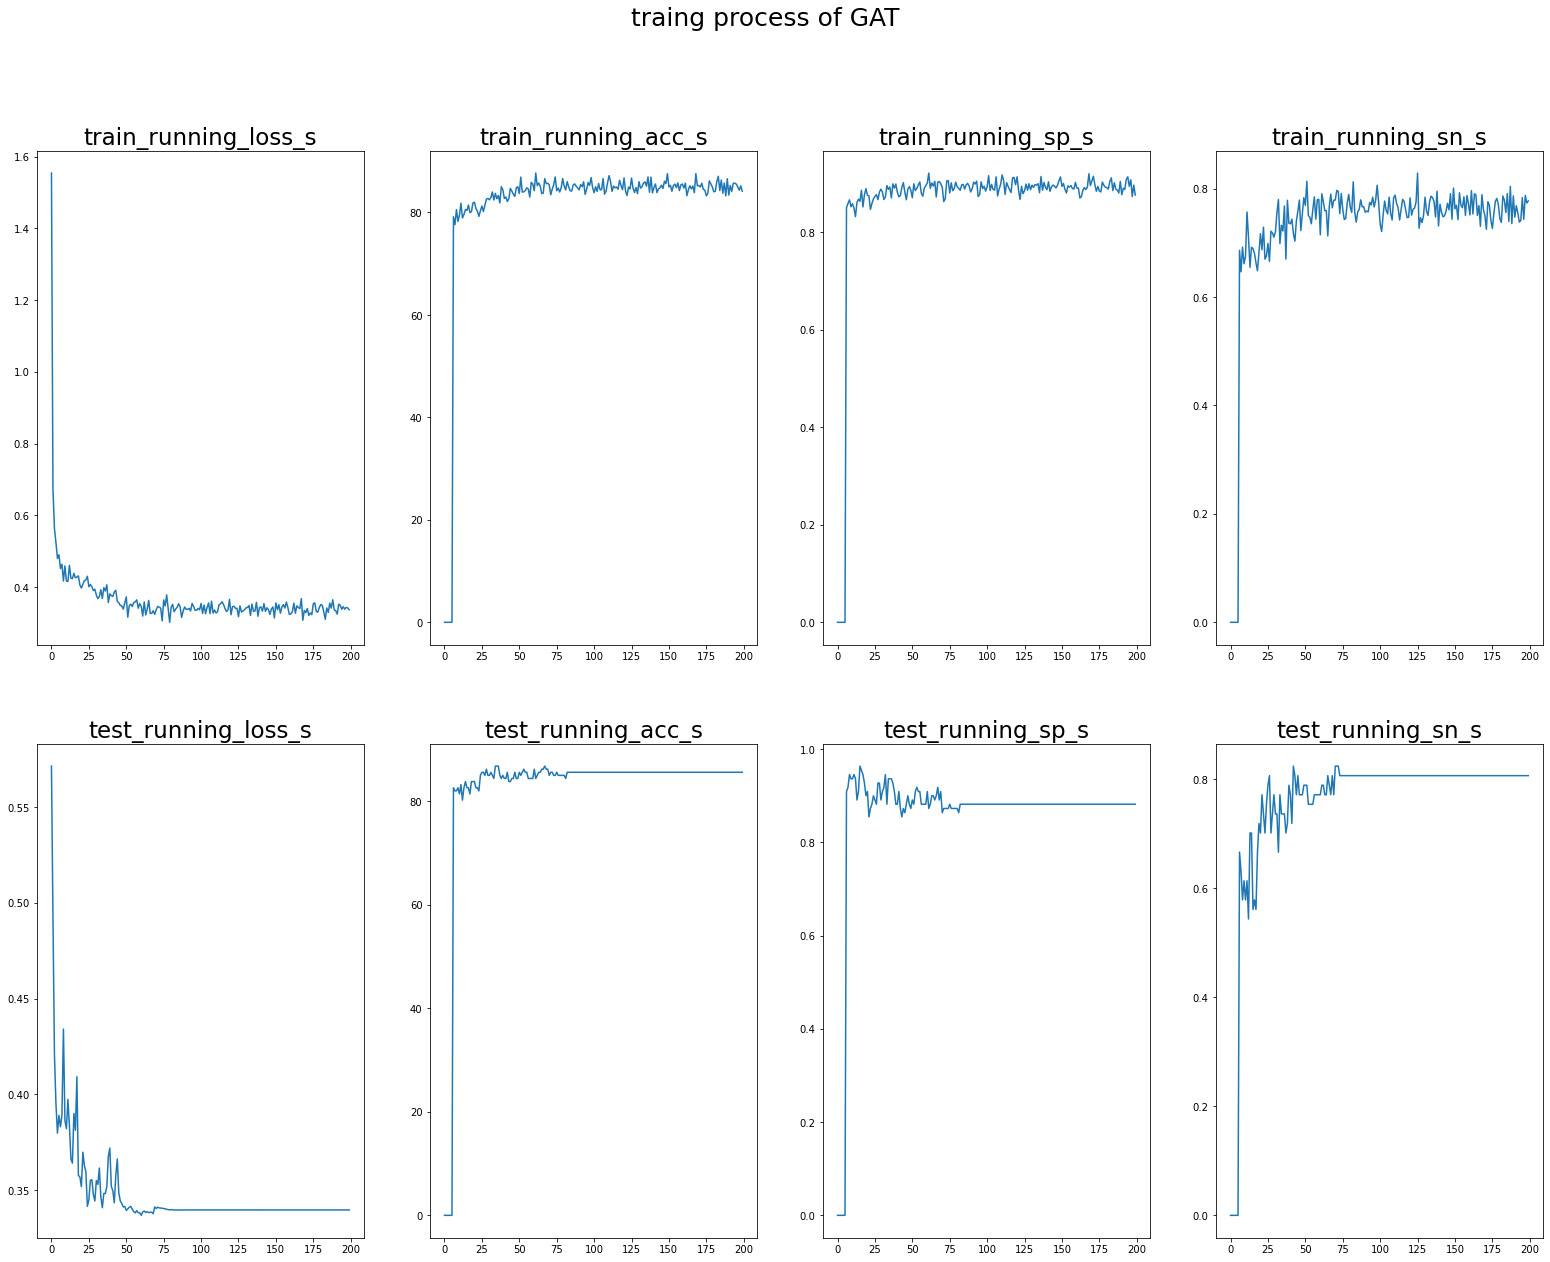

In [24]:
idx = 3
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 4, figsize = (27,20))


axs[0, 0].plot(list(range(len(train_running_loss_s[idx]))), train_running_loss_s[idx])
axs[0, 0].set_title('train_running_loss_s', fontsize=23)
axs[0, 1].plot(list(range(len(train_running_acc_s[idx]))), train_running_acc_s[idx])
axs[0, 1].set_title('train_running_acc_s', fontsize=23)
axs[0, 2].plot(list(range(len(train_running_sp_acc_s[idx]))), train_running_sp_acc_s[idx])
axs[0, 2].set_title('train_running_sp_s', fontsize=23)
axs[0, 3].plot(list(range(len(train_running_sn_acc_s[idx]))), train_running_sn_acc_s[idx])
axs[0, 3].set_title('train_running_sn_s', fontsize=23)

axs[1, 0].plot(list(range(len(test_running_loss_s[idx]))), test_running_loss_s[idx])
axs[1, 0].set_title('test_running_loss_s', fontsize=23)
axs[1, 1].plot(list(range(len(test_running_acc_s[idx]))), test_running_acc_s[idx])
axs[1, 1].set_title('test_running_acc_s', fontsize=23)
axs[1, 2].plot(list(range(len(test_running_sp_acc_s[idx]))), test_running_sp_acc_s[idx])
axs[1, 2].set_title('test_running_sp_s', fontsize=23)
axs[1, 3].plot(list(range(len(test_running_sn_acc_s[idx]))), test_running_sn_acc_s[idx])
axs[1, 3].set_title('test_running_sn_s', fontsize=23)
fig.suptitle('traing process of GAT', fontsize = 25)




## Feature Visualization

In [22]:
from sklearn import manifold, preprocessing
from matplotlib.ticker import NullFormatter
from time import time
n_components = 2
perplexities = [45, 47]

In [23]:
train_dataset, train_dataloader = get_dataloader(train_data, 
                             len(train_data), 
                             False, 
                             collate_molgraphs, 
                             True)
test_dataloader  = get_dataloader(df=test_data, 
                              batch_size=len(test_data), 
                              shuffle=False,
                              collate_fn=collate_molgraphs) 
valid_dataloader = get_dataloader(df=valid_data, 
                              batch_size=len(valid_data), 
                              shuffle=False,
                              collate_fn=collate_molgraphs)

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...


In [28]:
logits   = []
readouts = []
atts = []
for idx, batch_data in enumerate(train_dataloader):
    # step 1: 准备数据
    smiles, graphs, labels, masks = batch_data
    graph, labels, masks = graphs.to(args.device), labels.long().to(args.device), masks.to(args.device)
    # step 2: 拟合数据
    for model in models:
        logit, readout, att = fit(args, model, graphs)
        logits.append(logit.detach())
        readouts.append(readout.cpu().detach().numpy())
    idxs_correct, _, _, _ = vote(logits, labels, args.device)

readouts = torch.FloatTensor(readouts)
readouts = torch.mean(readouts, dim=0)
logits   = np.array([logit.detach().numpy() for logit in logits])
logits   = np.mean(logits, axis = 0)

## 获取正确预测的数据
#idxs_correct = torch.max(logits, dim=1)[1].detach().cpu().numpy() == torch.squeeze(labels).detach().cpu().numpy()

y = torch.squeeze(labels).numpy()
X = readouts.detach().numpy()

torch.Size([837])


In [30]:
red   = y == 0
green = y == 1

In [ ]:
(fig, subplots) = plt.subplots(1, 1, figsize=(8, 8))
ax = subplots
ax.scatter(logits[red, 0], logits[red, 1], c="r")
ax.scatter(logits[green, 0], logits[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

circles, perplexity=45 in 2.3 sec
circles, perplexity=47 in 2.4 sec


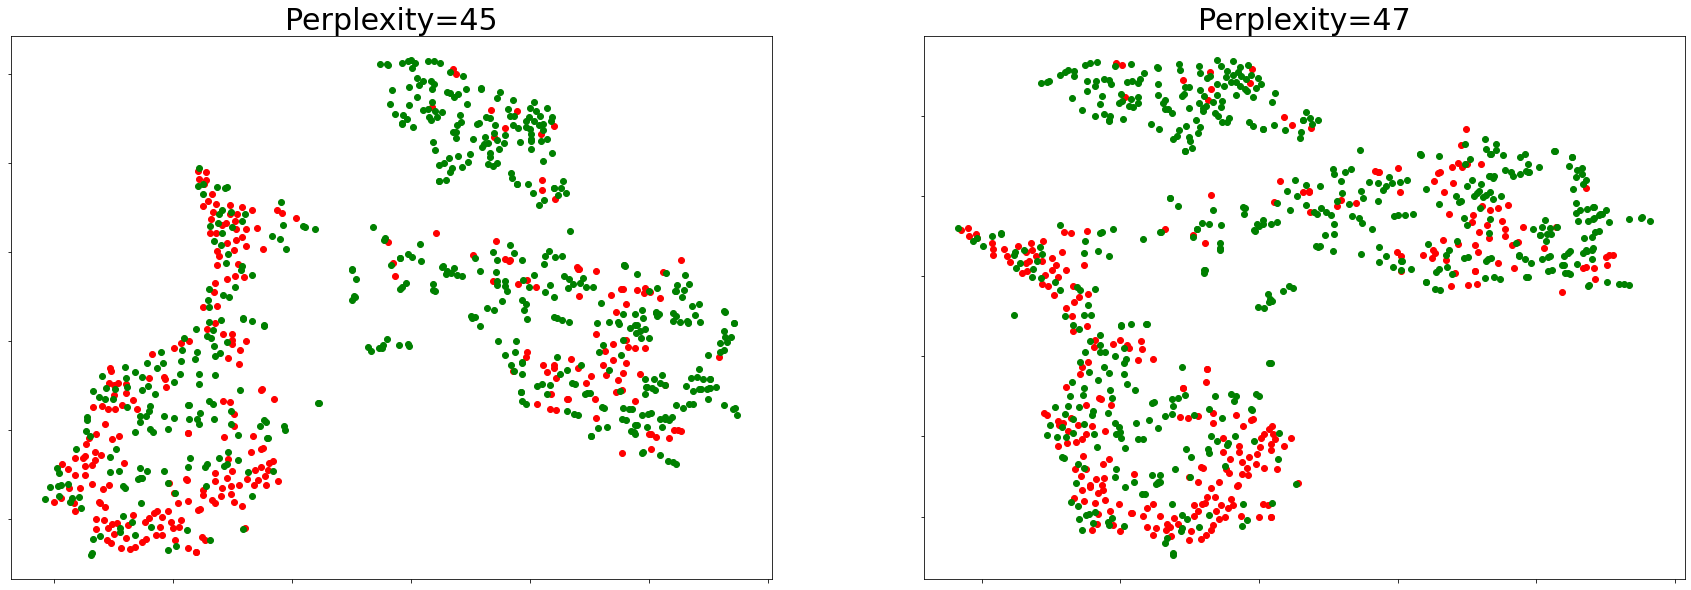

In [29]:
(fig, subplots) = plt.subplots(1, len(perplexities), figsize=(30, 10))

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',learning_rate=400, n_iter=1000,
                         random_state=args.seed, perplexity=perplexity)
    Y = tsne.fit_transform(readouts)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    
    ax.set_title("Perplexity=%d" % perplexity, fontsize=30)
    ax.scatter(Y[red, 0], Y[red, 1], c="r")
    ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
plt.show()

## Attention analysis


In [31]:
import copy
import dgl
import matplotlib
import matplotlib.cm as cm
import torch

from functools import partial
from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

from dgllife.data import PubChemBioAssayAromaticity
from dgllife.model import load_pretrained
from dgllife.utils.featurizers import BaseAtomFeaturizer, ConcatFeaturizer, atom_type_one_hot, \
    atom_degree_one_hot, atom_formal_charge, atom_num_radical_electrons, \
    atom_hybridization_one_hot, atom_total_num_H_one_hot, BaseBondFeaturizer

In [32]:
# 分开正确预测的化合物，并且分开RB和NRB的化合物
_lable = labels.detach().cpu().numpy()
RB_idx = []
NRB_idx = []
for idx, flag in enumerate(idxs_correct):
    if flag :
        if _lable[idx] == 0:
            RB_idx.append(idx)
        else:
            NRB_idx.append(idx)

In [33]:
def svg_draw(mol, g, node_attention, bond_attention):
    """
        mol_to_svg:
        args:
            mol: mol object of rdkit
            grapg: 
            node_attention: 节点attention
            bond_attention: 节点attention
        return: svg
    """
    # 绘制edge_attention
    min_value = torch.min(bond_attention)
    max_value = torch.max(bond_attention)
    bond_attention = (bond_attention - min_value) // (max_value - min_value) # normalization
    # Conver the weights to atom colors
    #norm = matplotlib.colors.Normalize(vmin=0, vmax=1.0)
    norm = matplotlib.colors.Normalize(vmin=min_value, vmax=max_value)
    cmap = cm.get_cmap('Accent')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    bond_colors = {i: plt_colors.to_rgba(bond_attention[i*2].data.item()) for i in range((g.number_of_edges()-g.number_of_nodes())//2)}

    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(500,250)
    drawer.SetFontSize(1)
    op = drawer.drawOptions()

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    print(len(bond_colors), len(list(range(g.number_of_edges() // 2))))
    drawer.DrawMolecule(mol,highlightAtoms=None,highlightBonds=list(range(len(bond_colors))), highlightBondColors=bond_colors)

    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    return svg

In [34]:
def draw(mol_idxs,  dataset, model, col=None):
    """Visualize the learned atom weights in readout && bond attention.
    
    Parameters
    ----------
    mol_id : int
        Index for the molecule to visualize in the dataset.
    dataset
        As the model has multiple rounds of readout, an additional
        index is used to specify the round for the weights.
    """
    # Get the weights from the model.

    smiles = []
    graphs = []
    for idx in mol_idxs:
        smile, g, _, _ = dataset[idx]
        smiles.append(smile)
        graphs.append(g)
    
    bg = dgl.batch(graphs)  
    for idx, smile in enumerate(smiles):
        print("idx = ", idx, "smile = ", smile)

    """ 
    print("g.node = ", g.number_of_nodes())
    print("g.edge = ", g.number_of_edges()) 
    """
    #print("bg_batch.node = ", bg.batch_num_nodes())
    #print("bg_batch.edge = ", bg.batch_num_edges()) 
    logit, readout, bond_attentions = fit(args, model, bg)
    bond_attention_split = []
    if col is not None: 
        bond_attentions = torch.squeeze(bond_attentions)[:, col]
        for i in range(len(bg.batch_num_edges())):
            if i == 0:
                bond_attention = bond_attentions[0:bg.batch_num_edges()[0].item()]
            else:
                bond_attention = bond_attentions[
                    torch.sum(bg.batch_num_edges()[:i]).item():
                    torch.sum(bg.batch_num_edges()[:i+1]).item()]
            bond_attention_split.append(bond_attention)
    else:
        for i in range(len(bg.batch_num_edges())):
            if i == 0:
                bond_attention, _= torch.max(bond_attentions[0:bg.batch_num_edges()[0].item()], dim=1)
            else:
                bond_attention, _= torch.max(bond_attentions[
                    torch.sum(bg.batch_num_edges()[:i]).item() :
                    torch.sum(bg.batch_num_edges()[:i+1]).item()
                    ], dim=1)
                bond_attention = torch.tensor([1 if i > 0.5 else  0 for i in bond_attention.detach().cpu()])
            bond_attention_split.append(bond_attention)
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    #print(bond_attention_split[i].shape)
    svgs = [svg_draw(mols[i], graphs[i], None, bond_attention_split[i].squeeze()) for i in range(len(graphs))]
    for i in range(len(graphs)):
        display(SVG(svgs[i]))

idx =  0 smile =  CC#N
idx =  1 smile =  OC(=O)c1ccc2ccccc2c1
2 3
14 20


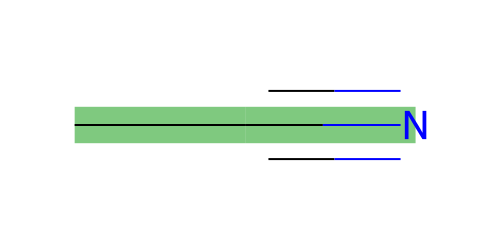

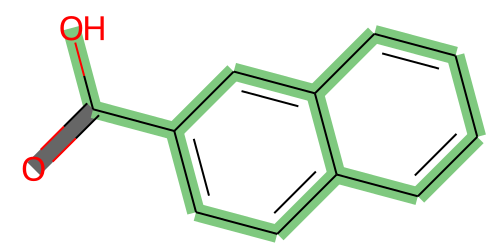

In [60]:
draw(RB_idx[198:200], train_dataset, model1)